# <font color=#295172>Part 1 of 4 - Exploratory Data Analysis</font>

#### <font color=#6185a0>| Final Capstone Project for the Diploma Program in Data Science | BrainStation Vancouver |</font>

<font color=#6185a0>| Arash Tavassoli | May-June 2019 |</font>

---
This is the first notebook in a series of four:
* **<font color=#cc6900>Part 1 - Exploratory Data Analysis</font>**

* **Part 2 - Data Preprocessing**

* **Part 3 - Model Training and Analysis**

* **Part 4 - Real-Time Facial Expression Recognition**

### What to expect in this notebook:

1. A brief intoroduction to the project
2. Exploratory data analysis on the dataset and initial filtering of the data
3. Defining the expected model accuracy (Bayes error and human error)
---
## 1. Introduction:
The field known as Facial Expression Recognition (FER) represents an Image Classification problem within the wider field of Computer Vision that is deemed of significant academic and commercial potential. 

While machine learning systems may be trained to accurately recognize the emotional expressions from images of human faces, the task still remains to be a challenge for a variety of reasons, including but not limited to absence of publicly availabile, high-quality labelled images, the subtle differences between some facial expressions (e.g. sad and neutral) and the computationally expensive training process.

In this project, a machine learning system is developed to recognize emotional expressions (e.g. Happiness, Sadness, Anger or Surprise) from images of human faces using a deep-learning implementation of Convolutional Neural Networks (CNN) using TensorFlow (Keras) and OpenCV in Python.

### 1.1. Motivation
This project is completed as the Capstone project for my 12-week, immersive, full-time, [Diploma program in Data Science at BrainStation Vancouver](https://brainstation.io/course/vancouver/data-science-bootcamp) but stems from my life-long interest in understanding how the computers detect faces and process images of such nature. It was also motivated by my interest in facing the challenge of dealing with large-sized data and computationally expensive data processing and machine kearning training process.

### 1.2. The Project at a Glance

Below shows a brief summary of the steps taken in this project, which will be further discussed in the 4 Jupyter Notebooks listed above:

<img src="Data/Images/ProjectFlow.png" style="width: 900px;"/>

### 1.3. Data Source
The main dataset for this project is the [AffectNet Dataset](http://mohammadmahoor.com/affectnet/), which is a relatively new dataset of facial expressions in the wild and contains over 1 million facial images collected from Internet by querying major search engines using 1250 emotion related keywords in six different languages. About half of the retrieved images (~440K) are manually annotated and the rest are labelled automatically using a trained model. AffectNet is gathered by a research group at University of Denver and was generously shared with me for research use in this project. The size of the database is over 120GB, which represents a challenge when it come to preprocessing and model training.

**Citation:** Ali Mollahosseini, Behzad Hasani, and Mohammad H. Mahoor, “AffectNet: A New Database for Facial Expression, Valence, and Arousal Computation in the Wild”, IEEE Transactions on Affective Computing, 2017

The other datasets that were used in the early stages of the model development were [Extended Cohn-Kanade Dataset (CK+)](http://www.consortium.ri.cmu.edu/ckagree/) and [FEI Face Database](https://fei.edu.br/~cet/facedatabase.html) that are not presented in this notebook. 

### 1.4. Tech Stack
Python (Jupyter Notebook for local computations and Google Colab for training the model on Google GPUs), OpenCV, Keras and TensorFlow.

---
## 2. Exploratory Data Analysis:


As the very first step, we look at the AffectNet dataset to get a better understanding of the available data, its limitations and expected challenges.

Let's start by importing the libraries that we'll need in this part:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

The AffectNet dataset has come with three file lists with the sub-directory filepath and associated meta-data (including class label) listed for each image; two separate lists for the manually annotated images (splitted for training and validation) and one list for the remaining automaticcaly annotated images:

In [2]:
# Root folder path for where the raw images and file lists are saved
root_dir = '/Volumes/Arash External Drive/AffectNet Data'

# Importing the list of filepath and image metadata 
# (with added columns to distinguish between manually/auto annotated images)
file_list_manual1 = pd.read_csv(root_dir + '/Manually_Annotated_file_lists/training.csv')
file_list_manual1['annotation'] = 'manual'

file_list_manual2 = pd.read_csv(root_dir + '/Manually_Annotated_file_lists/validation.csv')
file_list_manual2['annotation'] = 'manual'

file_list_auto = pd.read_csv(root_dir + '/Automatically_annotated_file_list/automatically_annotated.csv')
file_list_auto['annotation'] = 'auto'

# Concatenating all lists into one master file_list
file_list = pd.concat([file_list_manual1, file_list_manual2, file_list_auto]).reset_index(drop = True)

file_list.head(3)

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal,annotation
0,689/737db2483489148d783ef278f43f486c0a97e140fc...,134,134,899,899,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,1,0.785714,-0.055556,manual
1,392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b5532...,20,20,137,137,28.82;77.52;29.12;93.25;31.04;108.51;33.03;123...,0,-0.017253,0.004313,manual
2,468/21772b68dc8c2a11678c8739eca33adb6ccc658600...,11,11,176,176,30.52;87.33;32.55;106.43;36.94;125.81;43.06;14...,0,0.174603,0.007937,manual


During the data pre-processing phase, one of the images was found to be corrupted and must be removed from the master list:

In [3]:
path_to_corrupted_file = '103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg'
index = (file_list[file_list['subDirectory_filePath'] == path_to_corrupted_file]).index

file_list = file_list.drop(index)

Next, we use the class names and get a summary of data availability for each class:

In [3]:
# Defining expression names
expression_summary = pd.DataFrame([[0, 'Neutral'], [1, 'Happiness'], [2, 'Sadness'], [3, 'Surprise'], 
                                   [4, 'Fear'], [5, 'Disgust'], [6, 'Anger'], [7, 'Contempt'], 
                                   [8, 'None'], [9, 'Uncertain'], [10, 'No-Face']], 
                                  columns = ['Expression Code', 'Expression Name'])

# Adding counts for each class
expression_summary['Count (Total)'] = file_list.groupby(['expression']).size()
expression_summary['Count (Manually-Annotated)'] = file_list[file_list['annotation'] == 'manual'].groupby(['expression']).size()
expression_summary['Count (Auto-Annotated)'] = file_list[file_list['annotation'] == 'auto'].groupby(['expression']).size()

# Sorting based on Count (Total) columns
expression_summary = expression_summary.sort_values('Count (Total)', ascending=False).reset_index(drop=True)

display(expression_summary)

,Expression Code,Expression Name,Count (Total),Count (Manually-Annotated),Count (Auto-Annotated)
0,1,Happiness,381150,134915,246235
1,0,Neutral,218516,75374,143142
2,10,No-Face,153432,82915,70517
3,6,Anger,53382,25382,28000
4,2,Sadness,46813,25959,20854
5,8,None,40847,33588,7259
6,3,Surprise,32052,14590,17462
7,9,Uncertain,13592,12145,1447
8,4,Fear,10677,6878,3799
9,5,Disgust,5193,4303,890


Before proceeding, let's have a look at a sample image from each of the main classes:

In [5]:
# A function to load and show sample images from the manually annotated ones:
def image_viewer(index):
    file_dir = root_dir + '/Manually_Annotated_compressed/Manually Annotated Images/'
    
    sample_image = cv2.imread(file_dir + file_list['subDirectory_filePath'].iloc[index])
    expression_code = file_list['expression'].iloc[index]
    expression_name = expression_summary[expression_summary['Expression Code'] == expression_code]['Expression Name'].values[0]
    
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    plt.title(expression_name, fontsize=14);

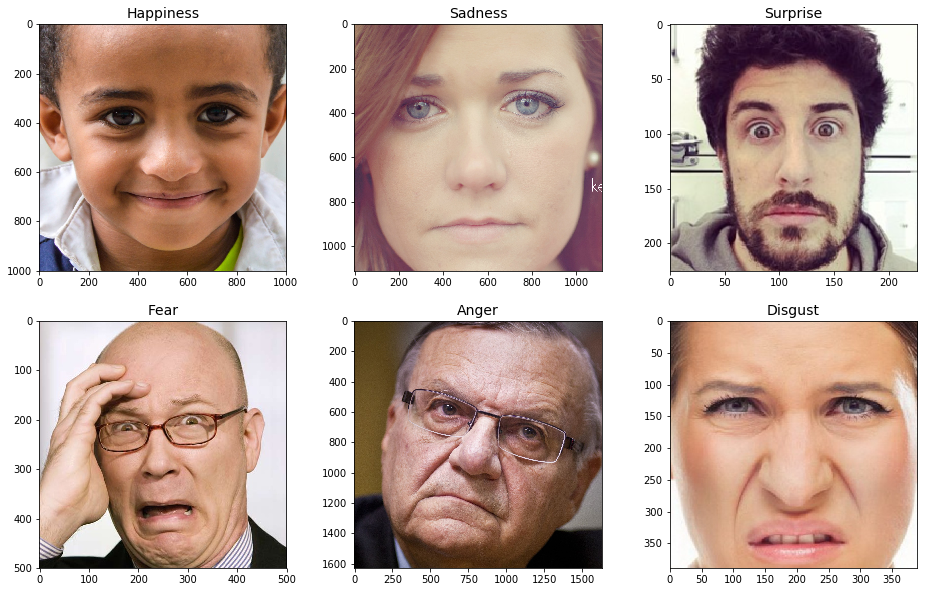

In [7]:
# Examples of Expressions:
plt.figure(figsize = (16,10))
gridspec.GridSpec(2,3)

plt.subplot2grid((2,3), (0,0))
image_viewer(85)

plt.subplot2grid((2,3), (0,1))
image_viewer(1959)

plt.subplot2grid((2,3), (0,2))
image_viewer(3638)

plt.subplot2grid((2,3), (1,0))
image_viewer(3666)

plt.subplot2grid((2,3), (1,1))
image_viewer(8244)

plt.subplot2grid((2,3), (1,2))
image_viewer(505)

Next, let's visualize the total number of images in each class:

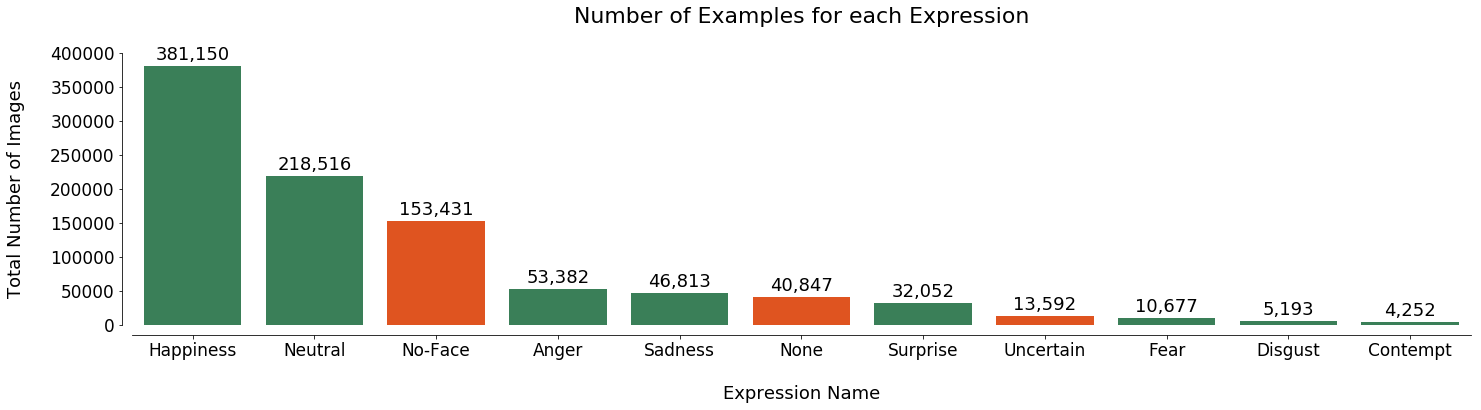

In [7]:
x = expression_summary['Expression Name']
y = expression_summary['Count (Total)']

# Marking the 'No-Face', 'None', 'Uncertain' classes as orange
custom_colors = ['orangered' if (i in ['No-Face', 'None', 'Uncertain']) else 'seagreen' for i in x]

plt.figure(figsize = (24,5))
sns.barplot(x, y, palette=custom_colors)
sns.despine(offset=10, trim=False)
plt.title('Number of Examples for each Expression', fontsize=22, pad = 30);
plt.xlabel('Expression Name', fontsize=18, labelpad=25)
plt.ylabel('Total Number of Images', fontsize=18, labelpad=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

for i, v in enumerate(y):
    plt.text(i, v + 9000, "{:,}".format(v), color='black', ha='center', fontsize=18);

It is clear from this graph that we're dealing with a considerable class imbalance in this dataset. A large portion of the data is on 'happy' and 'neutral' images, while minority classes 'fear', 'disgust' and 'contempt' are represented by a much smaller number of images.

Another one to note is that the 'no-face', 'none' and 'uncertain' classes add no meaningful value to the model, and therefore can be excluded from the dataset.

For the scope of this project, we will exclude the three minority classes 'fear', 'disgust' and 'contempt' as well as the 'no-face', 'none' and 'uncertain' classes. This will narrow down our focus on the following remaining categories:

In [16]:
expression_list = ['Happiness', 'Neutral', 'Anger', 'Sadness', 'Surprise']
expression_summary = expression_summary[expression_summary['Expression Name'].isin(expression_list)]

# Saving as one csv to be used in next parts:
expression_summary.to_csv('data/expression_summary.csv')

display(expression_summary)

,Expression Code,Expression Name,Count (Total),Count (Manually-Annotated),Count (Auto-Annotated)
0,1,Happiness,381150,134915,246235
1,0,Neutral,218516,75374,143142
3,6,Anger,53382,25382,28000
4,2,Sadness,46813,25959,20854
6,3,Surprise,32052,14590,17462


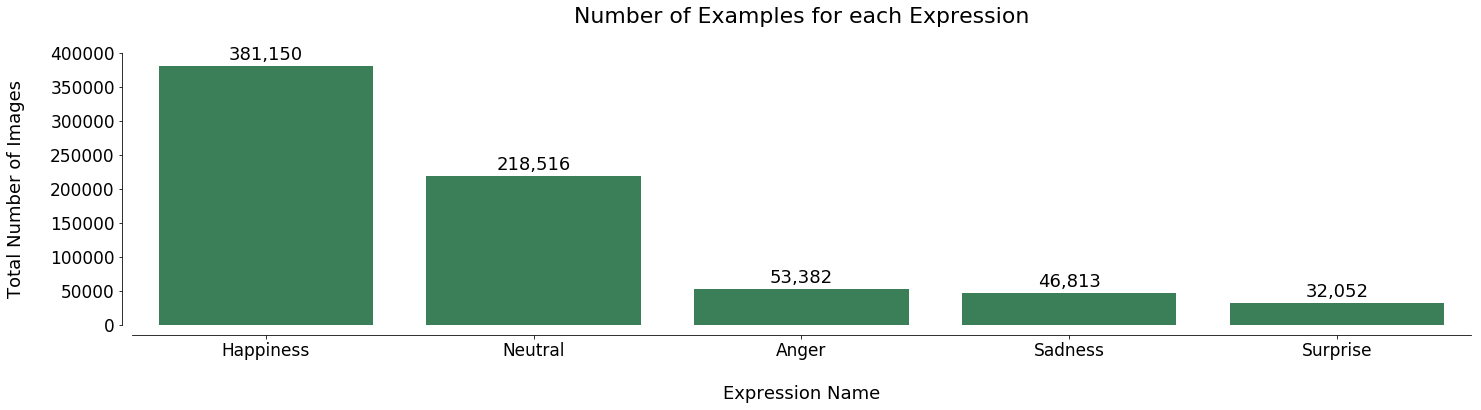

In [9]:
x = expression_summary['Expression Name']
y = expression_summary['Count (Total)']

plt.figure(figsize = (24,5))
sns.barplot(x, y, color='seagreen')
sns.despine(offset=10, trim=False)

plt.title('Number of Examples for each Expression', fontsize=22, pad = 30);
plt.xlabel('Expression Name', fontsize=18, labelpad=25)
plt.ylabel('Total Number of Images', fontsize=18, labelpad=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

for i, v in enumerate(y):
    plt.text(i, v + 9000, "{:,}".format(v), color='black', ha='center', fontsize=18);

We also filter our master file list to include only the images in which we are interested and export that list as a csv file to use in the next part (Part2):

In [20]:
expression_list = [0, 1, 2, 3, 6]
file_list = file_list[file_list['expression'].isin(expression_list)]

# Saving as one csv to be used in next parts:
file_list.to_csv('data/file_list.csv')

Before we wrap up, let's discuss one more concern, in preparation for the model training and interpretation sections. The need for the following analysis was identified during the model performance review process, but makes sense to be included in the current EDA notebook:

## 3. Defining the Expected Accuracy (Bayes and Human Error)

Through random sampling of the labelled images, the following issues were noticed:

1. There are mislabelled images in the dataset (e.g. an image which is a clear represetation of happiness is mistakenly labelled as angry)
2. Since the data is scraped from web, most images are not posed and are not taken with any controlled lighting, background or head position; therefore, some images are very hard to classify, even for a human user
3. There are many border-line images; i.e. the difference between some expressions is negligible in many of the faces

These issues are expected to affect the error level that is expected from even the most sophisticated machine learning systems (aka the Bayes' error). 

Bayes’ error is the theoretical lowest error that exists in a model. The human error, by definition, is always larger (worse) than Bayes' error, however the human error is usually very close to Bayes’ error, especially when it comes to image recognition (presumably, humans are really good at recognizing patterns). Thus, human error is usually used as a *proxy* for Bayes error.

To better understand our data and the trained models' performance we try to define the human error by:

1. Taking two random sample sets from the dataset. First a random sample of 1000 images from 5 classes of Happy, Sad, Surprised, Angry and Neutral (200 from each class), next a random sample of 600 images from the 3 classes of Happy, Sad and Surprised (200 from each class)
2. Manually going through the images and labelling them without knowledge of the "currect" label
3. Defining the human error as number of matching labels divided by total number of re-labelled data

As shown in the project summary flowchart above, the model training will be done in two streams. First with 5 classes as the output (Happy, Sad, Surprised, Angry and Neutral), and then with 3 classes as the output (Happy, Sad, Surprised).

Let's start doing some manual image labelling:

In [5]:
# A function to get the filtered list and ask for user's input (label) on each image,
# then return a dataframe with image index, true label (from original database) as well as user-defined label
def image_checker(filtered_list, num_samples, expression_str):
    image_index = []
    true_expressions = []
    user_input_expressions = []
    counter = 1

    for i in np.random.choice(num_samples, num_samples, replace=False):
        
        clear_output(wait = True)
        print(f'Image {counter}/{num_samples}:')
        counter += 1

        image_index.append(i)  
        true_expressions.append(filtered_list['expression'].iloc[i])

        if filtered_list['annotation'].iloc[i] == 'manual':
            file_dir = root_dir + '/Manually_Annotated_compressed/Manually Annotated Images/'
        elif filtered_list['annotation'].iloc[i] == 'auto':
            file_dir = root_dir + '/Automatically_Annotated_compressed/Automatically_Annotated_Images/'

        sample_image = cv2.imread(file_dir + filtered_list['subDirectory_filePath'].iloc[i])
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        plt.show();

        user_input = int(input(f'What is the facial expression in this image?\n{expression_str}: '))
        user_input_expressions.append(user_input)

    print(f'\nYou just classified {num_samples} images!')

    # Saving the labels in a dataframe
    manual_labels = pd.DataFrame({'Image Index': image_index, 
                                  'True Label': true_expressions, 
                                  'User Label': user_input_expressions})
    manual_labels['Match'] = manual_labels['True Label'] == manual_labels['User Label']
    
    return manual_labels

### 3.1 Labelling 1000 images from 5 Classes:
First we ask an un-biased user to manually label 1000 images with 200 images from each of the 5 classes (Happy, Sad, Surprised, Angry and Neutral):

Image 1000/1000:


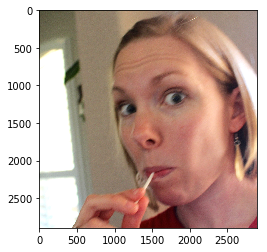

What is the facial expression in this image?
(0: Neutral, 1: Happy, 2: Sad, 3: Surprised, 6: Angry): 3

You just classified 1000 images!


In [31]:
# Creating a list of 1000 images with 200 images from each of the 5 classes
filtered_list_5classes = pd.DataFrame(columns = file_list.columns)
for expression in [0,1,2,3,6]:
    filtered_list_5classes = filtered_list_5classes.append(file_list[file_list['expression'] == expression].sample(200))

expression_str = '(0: Neutral, 1: Happy, 2: Sad, 3: Surprised, 6: Angry)'
num_samples = 1000

manual_labels_5classes = image_checker(filtered_list_5classes, num_samples, expression_str)
manual_labels_5classes.to_csv('data/manual_labels_5classes.csv')

In [32]:
# Calculate the accuracy for 5 classes:
acc = sum(manual_labels_5classes['Match']) / manual_labels_5classes.shape[0]
print(f'The accuracy on all 5 expressions:\t{(acc*100):.2f}%')

The accuracy on all 5 expressions:	69.30%


The 69.3% accuracy means that in 69.3% of images, the user's manual labels matched the dataset's "true" label. The low accuracy is partly explained by the subtle differences between some expressions (e.g. Neutral vs. Sad) as well as the fact that about 60% of the images in the dataset are automatically labelled using a trained model with less than 100% accuracy.

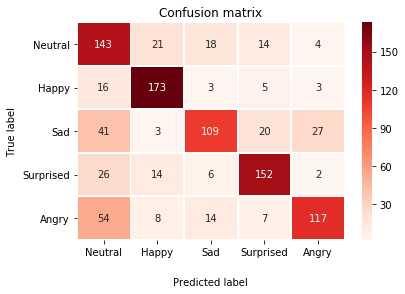

In [9]:
# Generatimng the confusion matrix for user labels and plotting on a heatmap:
expression_list =['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry']
conf_matrix = confusion_matrix(y_true = manual_labels_5classes['True Label'], 
                               y_pred = manual_labels_5classes['User Label'])
conf_matrix_df = pd.DataFrame(data = conf_matrix, columns = expression_list, index = expression_list)

sns.heatmap(conf_matrix_df, annot=True, cmap = 'Reds', fmt='g', linewidths = .8)
plt.ylabel('True label', labelpad = 5)
plt.xlabel('Predicted label', labelpad = 20)
plt.title('Confusion matrix')
plt.yticks(rotation=0);

With 200 images included from each class, the confusion matrix shows the highest recall (the proportion of total relevant results correctly classified by the user) on happy and surprised expressions. This may be explained by the fact that these two expressions have more extreme facial features than neutral vs. sad vs. angry.

### 3.1 Labelling 600 images from 3 Classes:
Next, we ask the un-biased user to manually label 600 images with 200 images from each of the 3 classes (Happy, Sad and Surprised):

Image 600/600:


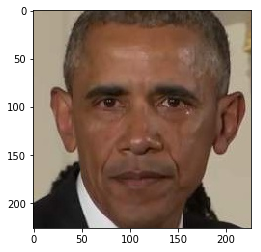

What is the facial expression in this image?
(1: Happy, 2: Sad, 3: Surprised): 2

You just classified 600 images!


In [6]:
# Creating a list of 600 images with 200 images from each of the 3 classes (Happy, Sad, Surprised):
filtered_list_3classes = pd.DataFrame(columns = file_list.columns)
for expression in [1,2,3]:
    filtered_list_3classes = filtered_list_3classes.append(file_list[file_list['expression'] == expression].sample(200))

expression_str = '(1: Happy, 2: Sad, 3: Surprised)'
num_samples = 600

manual_labels_3classes = image_checker(filtered_list_3classes, num_samples, expression_str)
manual_labels_3classes.to_csv('data/manual_labels_3classes.csv')

In [7]:
# Calculate the accuracy for 3 classes (Happy, Sad, Surprised):
acc = sum(manual_labels_3classes['Match']) / manual_labels_3classes.shape[0]
print(f'The accuracy on Happy, Sad and Surprised expressions:\t{(acc*100):.2f}%')

The accuracy on Happy, Sad and Surprised expressions:	84.83%


With the more-confusing classes of Neutral and Angry removed from the dataset, a more accurate match is achieved between the user and dataset labels.

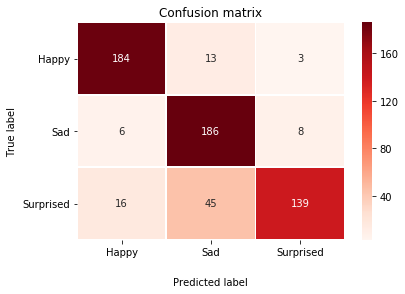

In [10]:
# Generatimng the confusion matrix for user labels and plotting on a heatmap:
expression_list =['Happy', 'Sad', 'Surprised']
conf_matrix = confusion_matrix(y_true = manual_labels_3classes['True Label'], 
                               y_pred = manual_labels_3classes['User Label'])
conf_matrix_df = pd.DataFrame(data = conf_matrix, columns = expression_list, index = expression_list)

sns.heatmap(conf_matrix_df, annot=True, cmap = 'Reds', fmt='g', linewidths = .8)
plt.ylabel('True label', labelpad = 5)
plt.xlabel('Predicted label', labelpad = 20)
plt.title('Confusion matrix')
plt.yticks(rotation=0);

We will further discuss the findings of this section on Notebook 3 and during the model analysis.